------

The Project Assignment for the Computational Statistics Course_ August 2020, M.Sc. Economics_ The University of Bonn_ [Solmaz Ahmadi](https://github.com/solmazahmadi/Computational-Statistics-Project)

------
<b>A simulation study inspired by the empirical paper of Breiman, L. (2001).

This notebook contains a simulation study using a realistic set-up from the following empirical paper as a motivation and benchmark:
>  ***Breiman, L. (2001). Random forests. Machine learning, 45(1), 5-32.***
* To access the original paper as well as the dataset click on [Random forests](https://www.stat.berkeley.edu/~breiman/random-forests.pdf) and [Boston housing dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/) from [StatLib](http://lib.stat.cmu.edu/datasets/boston), respectively.
* To see the codes for converting the .data fromat to .csv click on [Convert .data to .csv in Rstudio](https://github.com/solmazahmadi/Computational-Statistics-Project/blob/master/Convert%20.data%20to%20.csv%20in%20Rstudio.ipynb).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [29]:
# Read the Original Data Converted from .data to .csv  and Uploaded on Github
df = pd.read_csv('https://raw.githubusercontent.com/solmazahmadi/Computational-Statistics-Project/master/Data/Data_Original.csv')

#Take a Quick Look at the Head and Tail of Data Structure, and Define the Name of Each Rows as "District"
df.index.set_names("District", inplace = True)  
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
District,,,,,,,,,,,,,,
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9


Each row represents one district. Columns are 14 attributes including 13 (numeric and categorical) covariates as well as one target variable as median value of housing (you can see the description of dataset characteristics in [StatLib](http://lib.stat.cmu.edu/datasets/boston)). TO get a feel of the type of data, following steps are applied:

In [30]:
# Get a Quick Description of the Data on total number of rows, each attribute’s type and number of non-null values 
df.info()
# Detecting Missing Values in each of features
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

There are 506 observations in the dataset and all features have non-null values which is reported in the column of "Non-Null Count", also by using the df.isnull().sum() methed. When we looked at the "Dtype" column, we noticed that all  11 variables are continuous(float64) and 3 of them are discrete(int64) which are usual suspects for categorical variables. As mentioned in the description of characteristics, "CHAS"_Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)_ is a categorical variable but two other covariates ("CHAS" and "RAD") are not described as dummy or categorical variables. To identify whether our discrete variables are also categorical, we set a thereshold and use the length of their unique values as follows:

In [31]:
# If the lenght of unique values of the feature is less than 10, we treat that discrete feature 
# as a categorical variable
categorical_variables = []
threshold = 10
for i in df.columns:
    if len(np.unique(df[i]))<threshold:
        categorical_variables.append(i)
        
categorical_variables

['CHAS', 'RAD']

By following the abovementioned logic, "CHAS" and " RAD" are categorical variables on which we are applying  onehot coding later on. We treat "ZN" as a numberic variable with a discrete distribution. To check how many discretes belong to each category of each categorical variable, we use value_count() method as follows:


In [32]:
# The number of each categories in "RAD" and "CHAS"
df["RAD"].value_counts(), df["CHAS"].value_counts()

(24    132
 5     115
 4     110
 3      38
 6      26
 8      24
 2      24
 1      20
 7      17
 Name: RAD, dtype: int64,
 0    471
 1     35
 Name: CHAS, dtype: int64)

In [40]:
#Seperate Datasets for Categorical and Numeric Variables
categorical_variables = df[["CHAS", "RAD"]]
numeric_variables = df.drop(columns = ["CHAS", "RAD", "MEDV"])

To look at a summary of the attributes, the method of describe() is used.

In [41]:
df.describe().round(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000
mean,3.614,11.364,11.137,0.069,0.555,6.285,68.575,3.795,9.549,408.237,18.456,356.674,12.653,22.533
std,8.602,23.322,6.860,0.254,0.116,0.703,28.149,2.106,8.707,168.537,2.165,91.295,7.141,9.197
min,0.006,0.000,0.460,0.000,0.385,3.561,2.900,1.130,1.000,187.000,12.600,0.320,1.730,5.000
25%,0.082,0.000,5.190,0.000,0.449,5.886,45.025,2.100,4.000,279.000,17.400,375.378,6.950,17.025
50%,0.257,0.000,9.690,0.000,0.538,6.208,77.500,3.207,5.000,330.000,19.050,391.440,11.360,21.200
75%,3.677,12.500,18.100,0.000,0.624,6.624,94.075,5.188,24.000,666.000,20.200,396.225,16.955,25.000
max,88.976,100.000,27.740,1.000,0.871,8.780,100.000,12.126,24.000,711.000,22.000,396.900,37.970,50.000


To assess the descriptive statistics, we go with the example of "AGE" variable, count shows that there are 506 non_null observations with the mean of 68.6 and standard deviatoin (std) of 28. The minimum and maximum proportion of houses built before 1940 are 3 and 100 years, repectively. 25% of the towns have a proportion of housing built prior to 1940 lower than 45, while 50% are lower than 77.5 and 75% are lower than 94. These are often called the 25th percentile (or 1st quartile), the median, and the 75th percentile (or 3rd quartile).


# Plot a histogram for each of covariates
The histogram plot shows the number of observations (on the vertical axis) that have a given value range (on the horizontal axis) with the use of hist() method on the whole dataset, which will plot a histogram for each of covariates. For example, we can see that approximatly 30 districts have a
median_house_value equal to about $14,000.

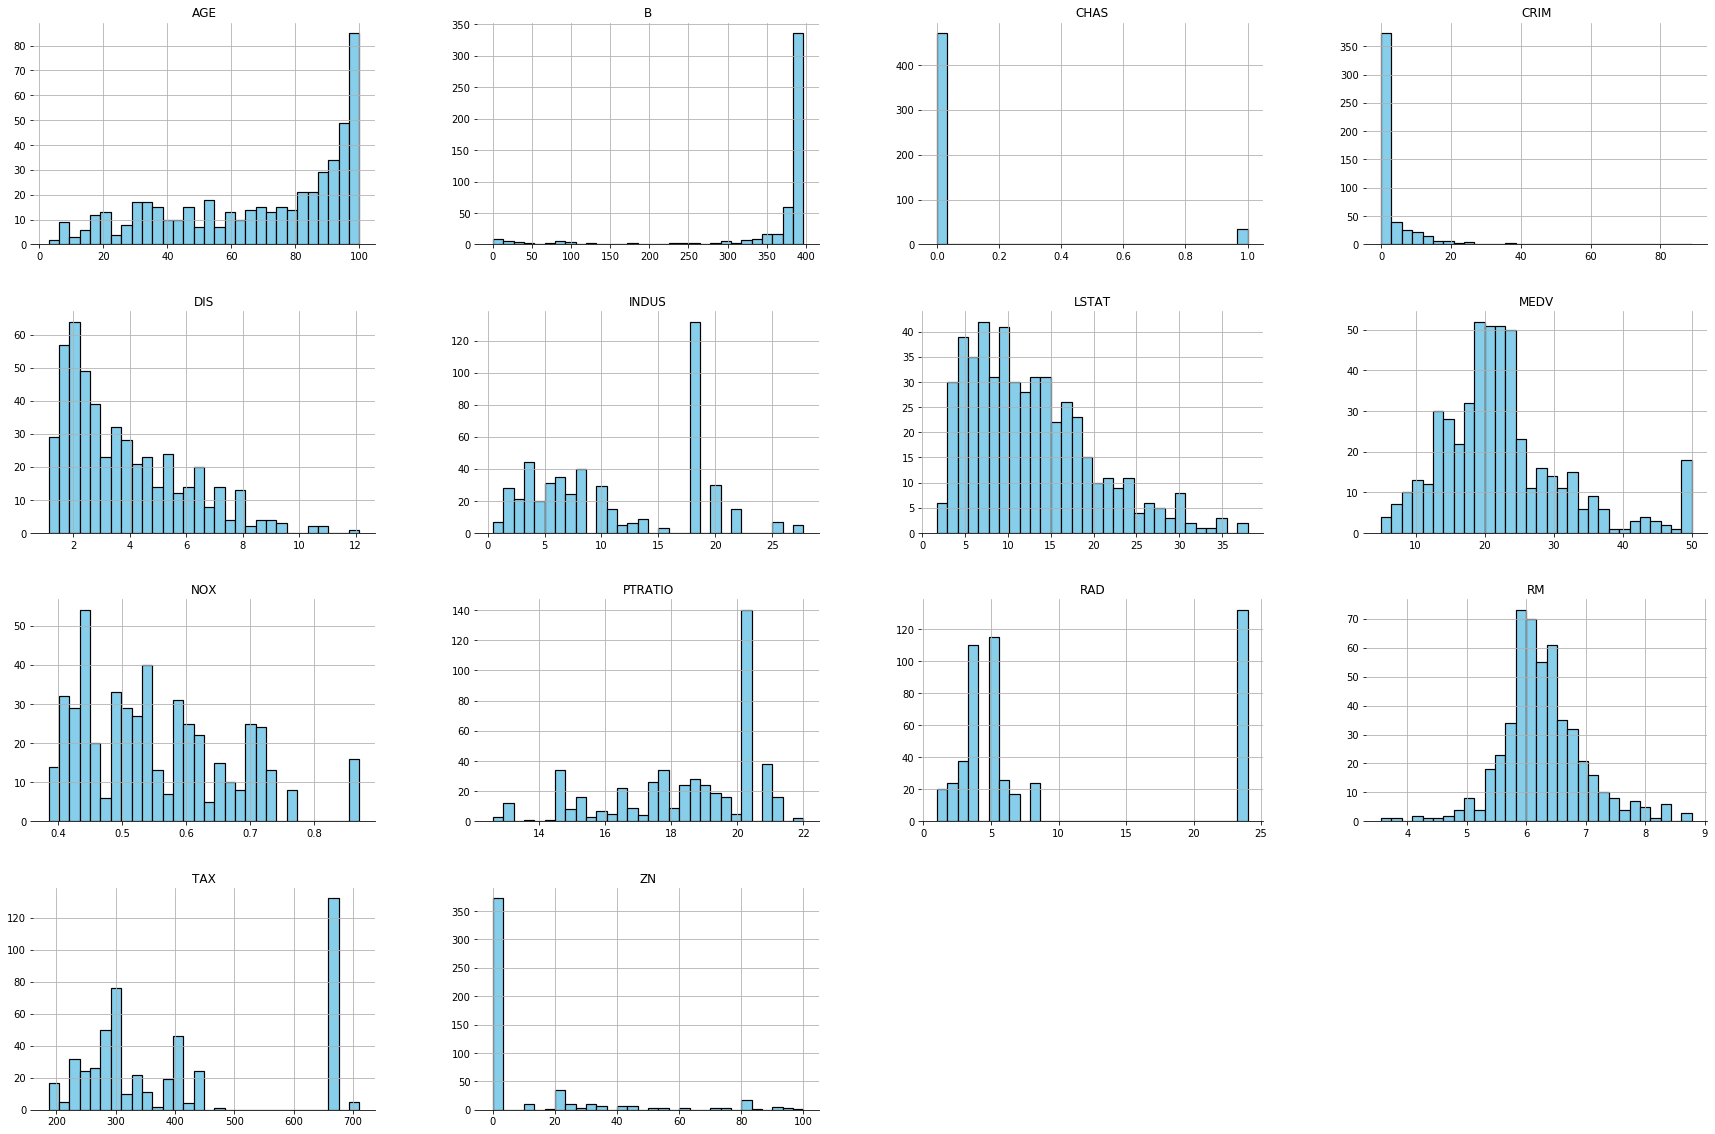

In [194]:
# Histogram plot for each of variables
import matplotlib.pyplot as plt
df.hist(bins=30, figsize=(30,20), edgecolor='black', linewidth=1.2, color = 'skyblue')
sns.despine(left=True)
plt.show()

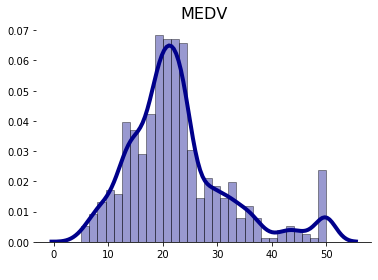

In [214]:
# Histogram plot for the target variable
sns.distplot(df["MEDV"], hist=True, kde=True, 
             bins=30, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, axlabel=' ')
plt.title('MEDV', fontsize=16)
sns.despine(left=True)

plt.show()

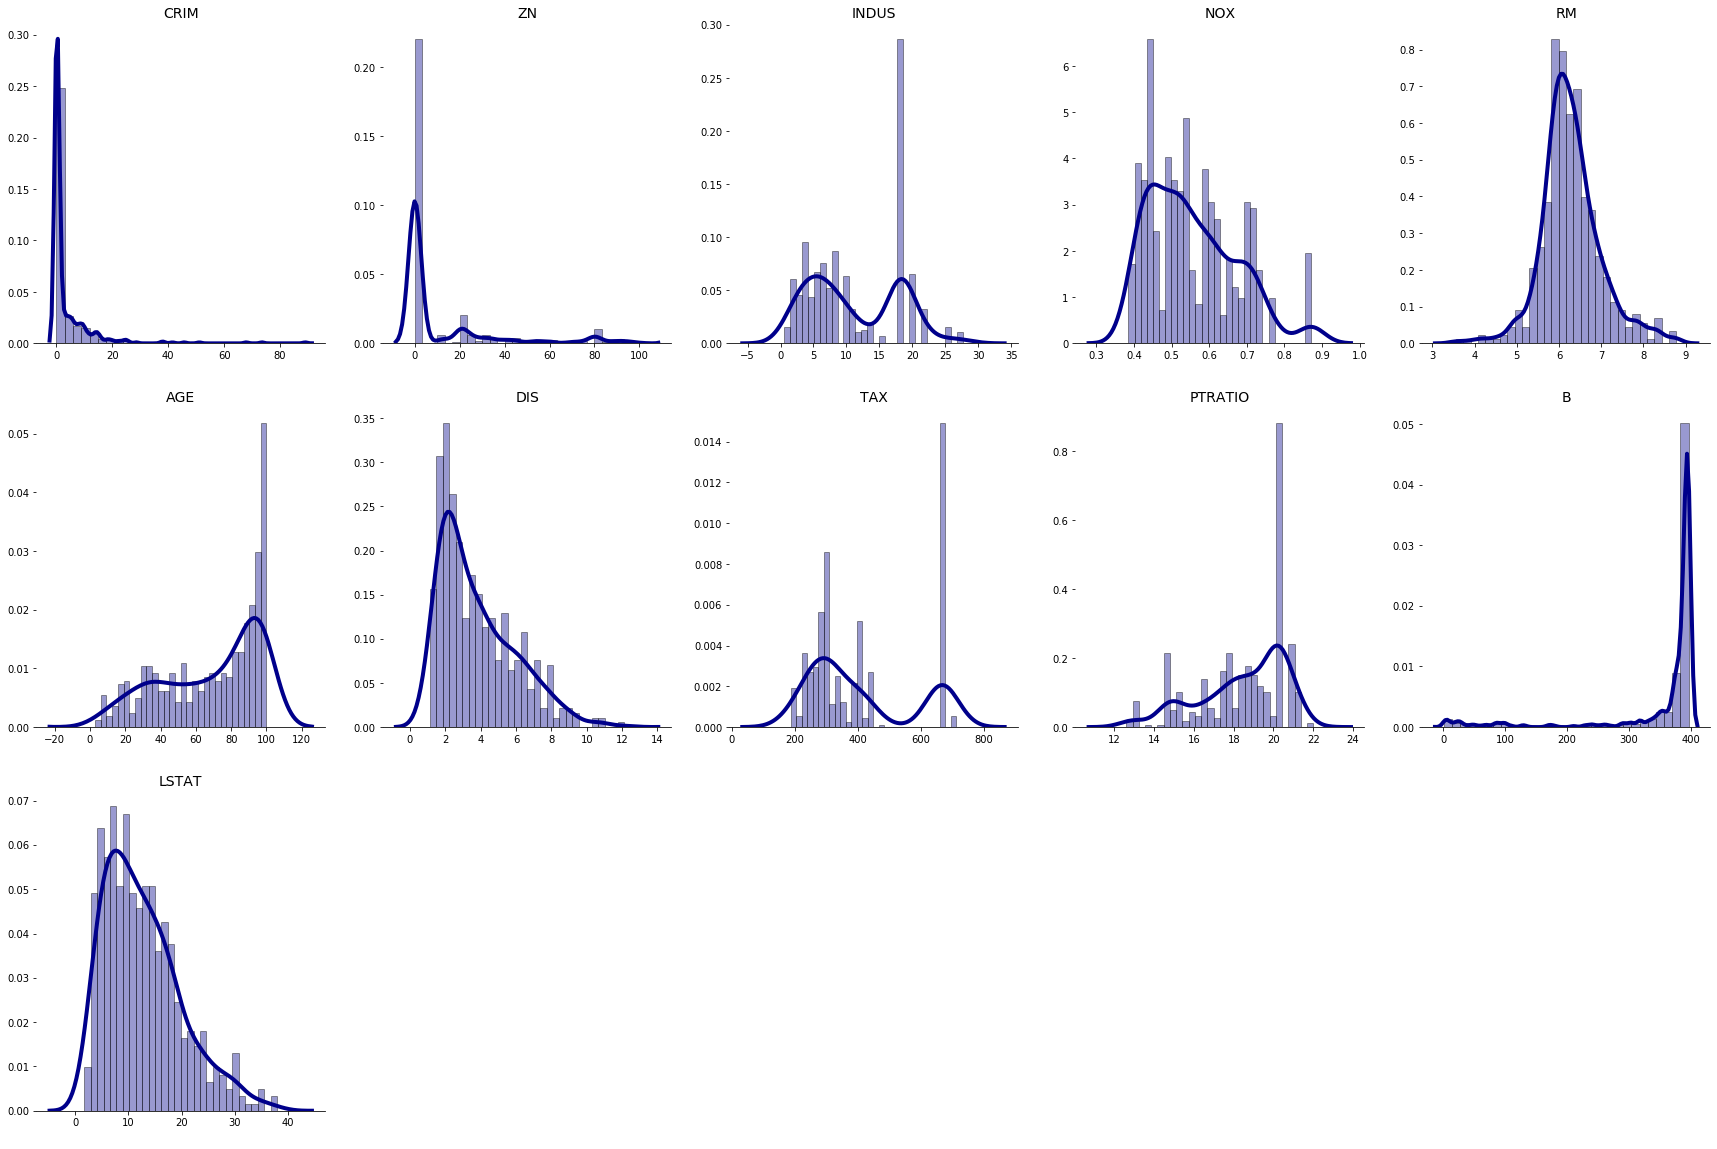

In [197]:
# Histogram plot for continuous variable
rowCnt = 3
colCnt = 5     
subCnt = 1     

fig = plt.figure(figsize=(30,20))

for column in numeric_variables.columns: 
    fig.add_subplot(rowCnt, colCnt, subCnt)
    plt.title(f'{column}'.format(rowCnt, colCnt, subCnt), fontsize=14)
    sns.distplot(df[column], hist=True, kde=True, bins=30, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, axlabel=' ')
    sns.despine(left=True)
    subCnt = subCnt + 1
    
plt.show() 
# https://www.kaggle.com/asimislam/tutorial-python-subplots

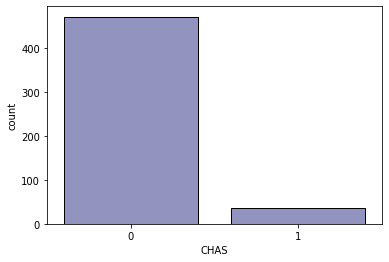

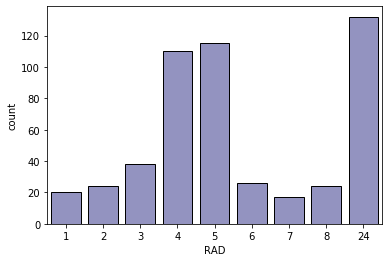

In [253]:
for column in categorical_variables:
    sns.countplot(df[column], edgecolor = 'black', color="#8C8BC7")
    plt.show()


Create a Test Set and set it aside to avoide data snooping bias
We pick 20% of the dataset randomly and set them aside as a test set. in order to split the dataset, we use the built_in function train_test_split in the package of scikit-Learn. First there is a random_state parameter that allows we to set the random generator seed, and second we can pass the datasets, and it will split them on the same indices.

In [255]:
# Split the dataset to train(0.8 of the dataset) and test (0.2 of the dataset) sets
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)


In [9]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas.io.formats.style

import statsmodels.api as sma

from IPython.display import HTML
from statsmodels.formula.api import ols
from collections import defaultdict
import statsmodels.distributions.empirical_distribution as ecdf

In [35]:
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
District,,,,,,,,,,,,,,
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9


In [36]:
#num_cols = df._get_numeric_data().columns
#num_cols
#df.columns
df["RAD"][df["RAD"]==1].count()

20

In [37]:
categorical_variables = []
threshold = 10
for i in df.columns:
    if len(np.unique(df[i]))<threshold:
        categorical_variables.append(i)
categorical_variables = df[["CHAS", "RAD"]]
numeric_variables = df.drop(columns = ["CHAS", "RAD", "MEDV"])

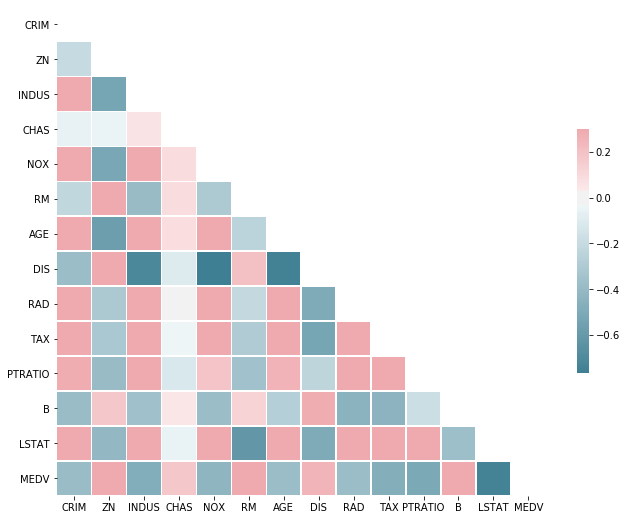

In [38]:
# Correlation heatmap
# Compute the correlation matrix
correlation_matrix = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
correlation_heatmap= sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [39]:
correlation_matrix

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


In [15]:
correlation_categorical_vriables = categorical_variables.corr()
correlation_categorical_vriables

,CHAS,RAD
CHAS,1.000000,-0.007368
RAD,-0.007368,1.000000


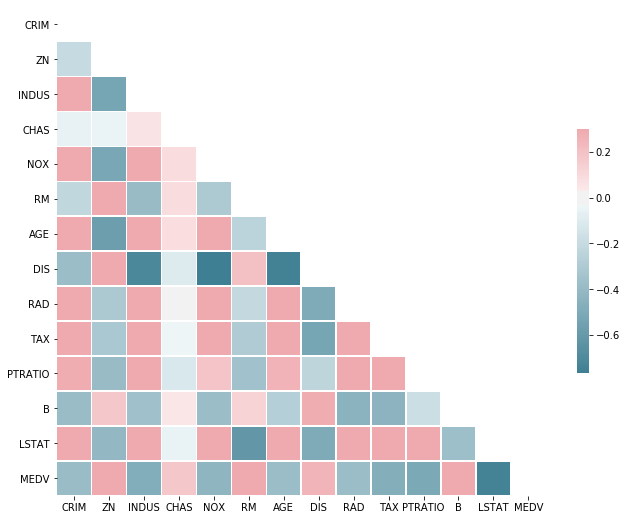

In [16]:
# Correlation heatmap
# Compute the correlation matrix
correlation_matrix = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
correlation_heatmap= sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

372

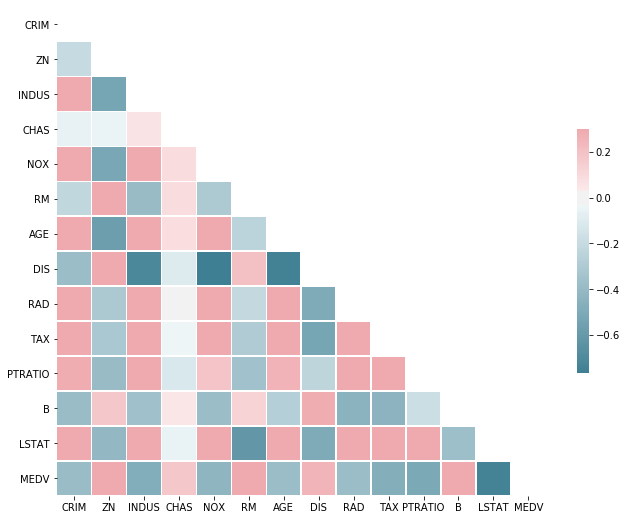

In [17]:
# Correlation heatmap
# Compute the correlation matrix
correlation_matrix = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
correlation_heatmap= sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
df["ZN"][df["ZN"]==0].count()

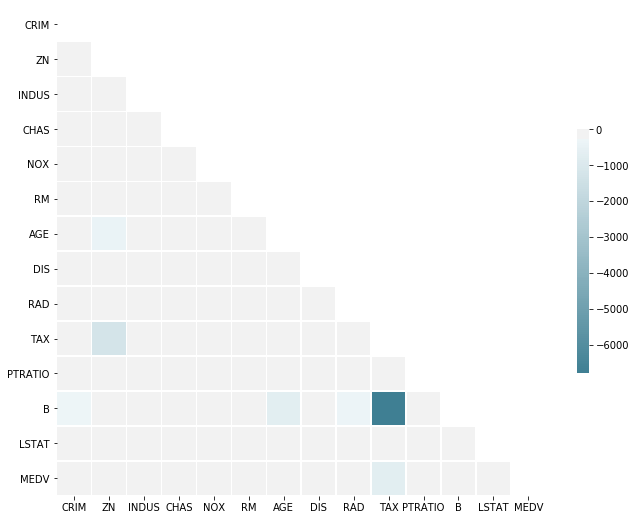

In [18]:
# Covariance heatmap
# Compute the correlation matrix
covariance_matrix = df.cov()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(covariance_matrix, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
correlation_heatmap= sns.heatmap(covariance_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [19]:
df.cov()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,73.986578,-40.215956,23.992339,-0.122109,0.419594,-1.325038,85.405322,-6.876722,46.847761,844.821538,5.399331,-302.381816,27.986168,-30.718508
ZN,-40.215956,543.936814,-85.412648,-0.252925,-1.396148,5.112513,-373.901548,32.629304,-63.348695,-1236.453735,-19.776571,373.721402,-68.783037,77.315176
INDUS,23.992339,-85.412648,47.064442,0.109669,0.607074,-1.887957,124.513903,-10.228097,35.549971,833.360290,5.692104,-223.579756,29.580270,-30.520823
CHAS,-0.122109,-0.252925,0.109669,0.064513,0.002684,0.016285,0.618571,-0.053043,-0.016296,-1.523367,-0.066819,1.131325,-0.097816,0.409409
NOX,0.419594,-1.396148,0.607074,0.002684,0.013428,-0.024603,2.385927,-0.187696,0.616929,13.046286,0.047397,-4.020570,0.488946,-0.455412
RM,-1.325038,5.112513,-1.887957,0.016285,-0.024603,0.493671,-4.751929,0.303663,-1.283815,-34.583448,-0.540763,8.215006,-3.079741,4.493446
AGE,85.405322,-373.901548,124.513903,0.618571,2.385927,-4.751929,792.358399,-44.329379,111.770846,2402.690122,15.936921,-702.940328,121.077725,-97.589017
DIS,-6.876722,32.629304,-10.228097,-0.053043,-0.187696,0.303663,-44.329379,4.434015,-9.068252,-189.664592,-1.059775,56.040356,-7.473329,4.840229
RAD,46.847761,-63.348695,35.549971,-0.016296,0.616929,-1.283815,111.770846,-9.068252,75.816366,1335.756577,8.760716,-353.276219,30.385442,-30.561228
TAX,844.821538,-1236.453735,833.360290,-1.523367,13.046286,-34.583448,2402.690122,-189.664592,1335.756577,28404.759488,168.153141,-6797.911215,654.714520,-726.255716


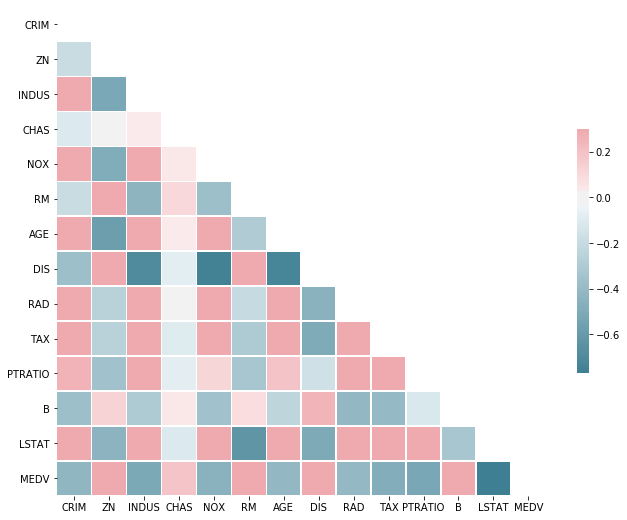

In [20]:
np.random.seed(1)
mean_covariates = df.mean()
covariance_matrix_covariates = df.cov()
simulation_covariates_ = pd.DataFrame(np.random.multivariate_normal(mean_covariates, covariance_matrix_covariates, 506))
simulation_covariates_.columns = df.columns

correlation_matrix = simulation_covariates_.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
correlation_heatmap= sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [21]:
simulation_covariates_


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,13.312665,20.328988,6.284977,0.118838,0.413414,7.415181,20.765748,6.997705,-4.427508,124.196219,16.178025,393.468331,5.918859,27.770710
1,-6.698531,12.143941,-0.059332,0.042530,0.445539,6.713662,38.588420,6.828666,0.249691,194.450495,18.102067,331.371657,11.475235,26.368812
2,7.302652,16.110608,9.276096,0.143615,0.545685,6.374611,54.395399,6.017672,17.393109,467.098649,19.272215,382.479304,6.814615,28.131392
3,-6.772791,-2.692097,17.400504,0.105160,0.614133,5.802698,74.462256,1.837719,13.505684,572.507971,19.479271,446.247746,18.475374,15.809270
4,-9.814755,23.270560,9.896993,-0.376868,0.572294,5.922018,72.551737,5.366104,-0.782731,289.144859,16.485315,470.022778,7.600043,30.949153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,1.579935,41.192966,-2.013863,0.246420,0.285604,6.556548,7.171321,5.457023,-1.532824,136.819799,18.176933,410.463207,6.151955,26.668391
502,-19.481857,25.741053,-4.551989,0.352931,0.376682,8.724080,-8.320457,5.983446,-5.882486,51.031567,15.666722,370.777012,-3.914995,47.728559
503,3.150176,-30.358997,11.214949,-0.080691,0.664600,6.540594,87.360894,1.354544,8.491962,356.055069,19.665407,356.607043,17.831445,17.956241
504,2.596419,5.645365,9.930620,-0.078525,0.576955,6.319998,56.352382,5.629629,10.335838,477.720969,20.073736,398.111769,18.845302,10.374446


In [22]:
for col_name in ["ZN", "CHAS", "RAD"]:
    simulation_covariates_[col_name] = np.where( simulation_covariates_[col_name] > df[col_name].max(), df[col_name].max(),  simulation_covariates_[col_name])
    simulation_covariates_[col_name] = np.where( simulation_covariates_[col_name] < df[col_name].min(), df[col_name].min(),  simulation_covariates_[col_name])
    simulation_covariates_[col_name] =  simulation_covariates_[col_name].round()



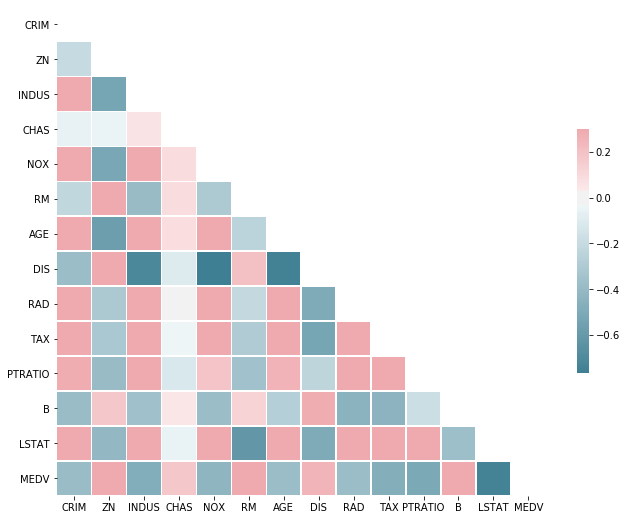

In [23]:


# Compute the correlation matrix
correlation_matrix = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
correlation_heatmap= sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

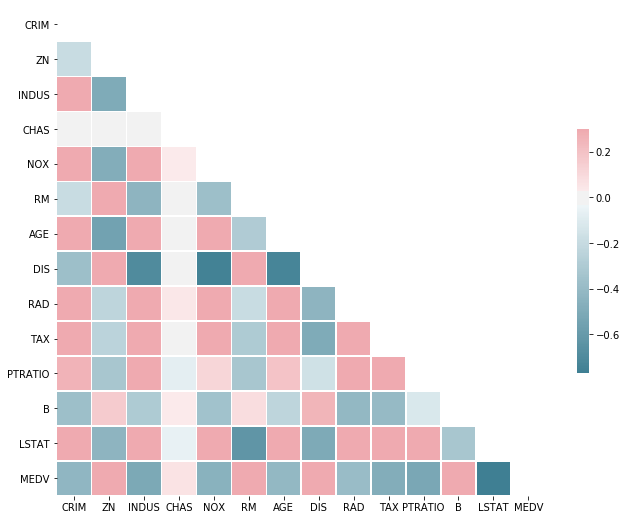

In [24]:
# Compute the correlation matrix
correlation_matrix = simulation_covariates_.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
correlation_heatmap= sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [25]:
from scipy import stats
stats.anderson_ksamp([df["CRIM"],simulation_covariates_["CRIM"]])


C:\Users\Solmaz\anaconda3\envs\Microeconometrics\lib\site-packages\ipykernel_launcher.py:2: UserWarning: p-value floored: true value smaller than 0.001
  


Anderson_ksampResult(statistic=67.1055549673307, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)

In [26]:
df["CHAS"] = np.random.choice([0,1], size = 506, replace = True, p = (471/506, 35/506))
df["RAD"] = np.random.choice([1,2,3,4,5,6,7,8,24], size= 506, replace=True, p=(20/506, 24/506, 38/506, 110/506, 115/506, 26/506, 17/506, 24/506, 132/506))
df["ZN"] = np.random.choice([18, 0, 12.5, 75, 21, 90, 85, 100, 25, 17.5, 80, 28, 45, 60, 95, 82.5, 30, 22, 20, 40, 55, 52.5, 70, 34, 33, 35], size = 506, replace = True, p = zn_count)

NameError: name 'zn_count' is not defined

In [ ]:
for i in ["CHAS","RAD", "ZN"]:
    simulation_covariates[i] = df[i]
simulation_covariates 

In [ ]:
simulation_covariates.cov()

In [ ]:
# Covariance heatmap
# Compute the correlation matrix
covariance_matrix_simulation = simulation_covariates.cov()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(covariance_matrix_simulation, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
correlation_heatmap= sns.heatmap(covariance_matrix_simulation, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# Covariance heatmap
# Compute the correlation matrix
covariance_matrix = df.cov()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(covariance_matrix, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
correlation_heatmap= sns.heatmap(covariance_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# Correlation heatmap
# Compute the correlation matrix
correlation_matrix = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
correlation_heatmap= sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# Compute the correlation matrix
correlation_matrix = simulation_covariates_.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
correlation_heatmap= sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:





zn_count = []
for i in [18 , 0, 12.5, 75, 21, 90, 85, 100, 25, 17.5, 80, 28, 45, 60, 95, 82.5, 30, 22, 20, 40, 55, 52.5, 70, 34, 33, 35]:
    zn_count.append(df["ZN"][df["ZN"]==i].count()/506)
zn_count

In [ ]:

    for i in ["ZN", "CHAS", "RAD"]: # iteration over each of categorical covariates(S3, C1, C2, C3, XC) for each cluster(each schoolid)      
  max_column = max(df[i])# Get the max of each categorical covariates
  min_column = min(df[i])# Get the min of each categorical covariates
  covar_sim[i][covar_sim_subsample[i] > max_column] = max_column # Keep the max of each categorical covariates in original data ,Make sure that the number of categoricals are the same 
  covar_sim[i][covar_sim_subsample[i] < min_column] = min_column     # Keep the min of each categorical covariates in original data
  #covar_sim_subsample[i] = round(covar_sim_subsample[i],digits =0) # rounding the number at the exteme of ranges

In [ ]:
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import t

mle_tuple_t = t.fit(df[["MEDV"]].values.flatten(), floc=df[["MEDV"]].values.mean())
mle_tuple_norm = norm.fit(df[["MEDV"]].values.flatten())

t_distr = t(*mle_tuple_t)
norm_distr = norm(*mle_tuple_norm)

In [ ]:
x = np.linspace(-60, 60, 1000)
                
ax = sns.distplot(df["MEDV"], kde=False, norm_hist=True, bins=500)
                
ax.plot(x, t_distr.pdf(x), linewidth=2.5, color="goldenrod")
ax.plot(x, norm_distr.pdf(x), linewidth=2.5, color="royalblue")

ax.legend(['t-distr.', 'normal-distr.'], prop={'size': 16})
plt.show()

In [ ]:
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)
ecdf(df["MEDV"])

In [ ]:
df["RAD"].unique(), df["CHAS"][df["CHAS"]==0].count()
df["ZN"].unique()

In [ ]:
# Density Plot and Histogram of all arrival delays
#for i in df.columns:
 #   sns.distplot(df[i], hist=True, kde=True, 
#         bins=int(180/5), color = 'darkblue', 
 #        hist_kws={'edgecolor':'black'},
#         kde_kws={'linewidth': 4})


In [ ]:
from scipy.stats import cumfreq
num_bins = 20
counts, bin_edges = np.histogram(numeric_variables, bins=num_bins, normed=True)
cdf = np.cumsum(counts)
plt.plot(bin_edges[1:], cdf)

In [ ]:
sns.distplot(df['CRIM'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [ ]:
sns.distplot(df['ZN'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [ ]:
sns.distplot(df['ZN'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [ ]:
covar_sim.ZN.max()

In [ ]:
df["CHAS"][df["CHAS"]==0].count()

In [27]:
simulation_covariates_['CHAS'] = np.where(simulation_covariates_['CHAS'] > simulation_covariates_["CHAS"].quantile(0.93), 1, 0)
simulation_covariates_['ZN'] = np.where(simulation_covariates_['ZN'] < simulation_covariates_["ZN"].quantile(0.74), 0, simulation_covariates_["ZN"].round())
simulation_covariates_['ZN'] = np.where(simulation_covariates_['RAD'] < simulation_covariates_["RAD"].quantile(0.04),1, simulation_covariates_["RAD"].round())
simulation_covariates_['CHAS'][simulation_covariates_['CHAS']==1].count()
simulation_covariates_['ZN'][simulation_covariates_['ZN']==0].count()
simulation_covariates_['RAD'][simulation_covariates_['RAD']==1].count()

89

In [28]:
scipy.stats.gaussian_kde(df["CRIM"])

NameError: name 'scipy' is not defined